In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import InceptionResNetV2

# Your code continues here...


In [4]:
train_dir =r'C:\Users\ELANGO S\ML-project\train1000'
test_dir =r'C:\Users\ELANGO S\ML-project\test1000'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path +"/"+ Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [11]:
# specifing new image shape for resnet
img_shape = 150
batch_size = 32
train_data_path = r'C:\Users\ELANGO S\ML-project\train1000'
test_data_path = r'C:\Users\ELANGO S\ML-project\test1000'


In [12]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 5600 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [13]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

tf.random.set_seed(42)
np.random.seed(42)

# Load InceptionResNetV2 model with pretrained weights and without the top classification layers
pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers in the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Create a new Sequential model
inceptionresnet_model = tf.keras.Sequential()

# Add the pretrained InceptionResNetV2 model to the new model
inceptionresnet_model.add(pretrained_model)

# Add GlobalAveragePooling2D layer to flatten the output
inceptionresnet_model.add(GlobalAveragePooling2D())

# Add a dense layer with 512 units and ReLU activation
inceptionresnet_model.add(Dense(512, activation='relu'))

# Add the output layer with appropriate units and activation for your task
inceptionresnet_model.add(Dense(7, activation='softmax'))  # Replace 7 with your actual number of classes

# Build the model with a specific input shape
input_shape = (150, 150, 3)
inceptionresnet_model.build((None, *input_shape))  # None is for batch size

# Compile the model with optimizer, loss, and metrics
inceptionresnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
inceptionresnet_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 3, 3, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,127,271 (210.29 MB)

 Trainable params: 790,535 (3.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [14]:
from tensorflow.keras.optimizers import Adam
inceptionresnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
epochs = 20
history = inceptionresnet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)

Epoch 1/20


C:\Users\ELANGO S\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - accuracy: 0.2612 - loss: 2.3286 - val_accuracy: 0.3486 - val_loss: 1.6754
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.3288 - loss: 1.7188 - val_accuracy: 0.3614 - val_loss: 1.6385
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 731s 4s/step - accuracy: 0.3511 - loss: 1.6429 - val_accuracy: 0.3864 - val_loss: 1.6277
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 862s 5s/step - accuracy: 0.3756 - loss: 1.6089 - val_accuracy: 0.4100 - val_loss: 1.5452
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 775s 4s/step - accuracy: 0.3991 - loss: 1.5802 - val_accuracy: 0.4114 - val_loss: 1.5521
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 868s 5s/step - accuracy: 0.3909 - loss: 1.5822 - val_accuracy: 0.4121 - val_loss: 1.5642
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.4058 - loss: 1.5420 - val_accuracy: 0.4286 - val_loss: 1.5234
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 789s 5s/step - accuracy: 0.4049 - loss: 1.5283 - val_accuracy: 0.401

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the directory path where your test data is located
test_data_dir =  r'C:\Users\ELANGO S\ML-project\test1000'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing steps here if needed

# Load test data using flow_from_directory
test_data_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),  # Adjust the target size to match your model's input size
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for classification problems
    shuffle=False  # Important: set shuffle to False for test data to keep labels in order
)

# Concatenate the batches to get the full test data and labels
test_data_array = []
test_labels = []

try:
    for i in range(len(test_data_generator)):
        data, labels = test_data_generator[i]
        test_data_array.append(data)
        test_labels.append(labels)
    
    # Concatenate batches to get the full test data and labels
    test_data_array = np.concatenate(test_data_array)
    test_labels = np.concatenate(test_labels)
    
    # Print the shape of test data and labels to verify
    print('Test data shape:', test_data_array.shape)
    print('Test labels shape:', test_labels.shape)

    # Make predictions
    predictions = inceptionresnet_model.predict(test_data_array)

    # Convert predictions and true labels to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Calculate and print classification report
    print(classification_report(true_labels, predicted_labels))

    # Calculate and print confusion matrix
    print(confusion_matrix(true_labels, predicted_labels))

except Exception as e:
    print("Error occurred:", e)

Found 1400 images belonging to 7 classes.
Test data shape: (1400, 150, 150, 3)
Test labels shape: (1400, 7)
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       214
           1       0.62      0.30      0.40       111
           2       0.31      0.21      0.25       214
           3       0.62      0.63      0.62       219
           4       0.42      0.54      0.47       214
           5       0.36      0.35      0.35       214
           6       0.52      0.71      0.60       214

    accuracy                           0.45      1400
   macro avg       0.46      0.44      0.43      1400
weighted avg       0.44      0.45      0.44      1400

[[ 72   7  31  13  32  34  25]
 [ 31  33   6   8  12  12   9]
 [ 28   7  44  17  27  36  55]
 [ 19   0   8 138  19  18  17]
 [ 16   0  13  19 115  21  30]
 [ 39   3  28  18  45  74   7]
 [  4   3  14  10  22   8 153]]


In [20]:
train_loss, train_accu = inceptionresnet_model.evaluate(train_data)
test_loss, test_accu = inceptionresnet_model.evaluate(test_data)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

175/175 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.4737 - loss: 1.4045
44/44 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step - accuracy: 0.3691 - loss: 1.6893
final train accuracy = 46.98 , validation accuracy = 44.93


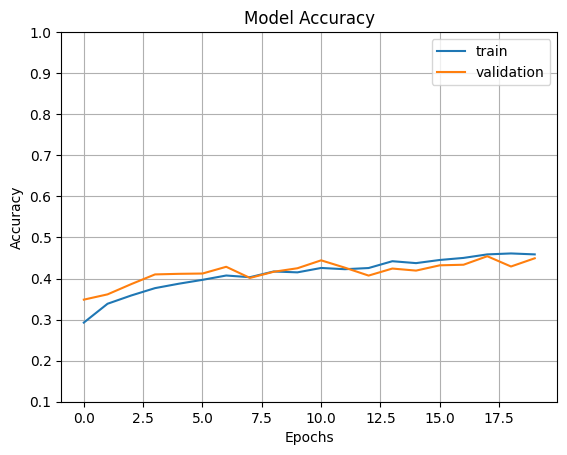

In [21]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show() 